In [7]:
import openeo
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np 

Authenticate with Copernicus.

In [8]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")

connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Below is a script which loads a specific dataset and then plots it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.055772666368914696..1.0].


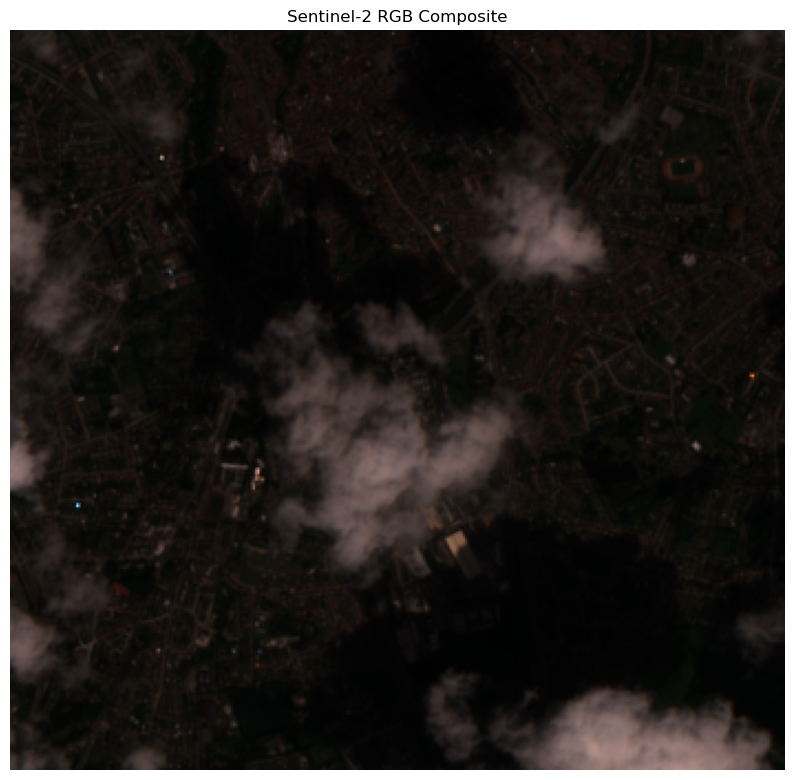

In [12]:
s2_cube = connection.load_collection(       # Load Sentinel-2 data collection
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 3.20,
        "south": 51.18,
        "east": 3.25,
        "north": 51.21,
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02"],
    max_cloud_cover=50,
)

output_file = "sentinel2_image.tif"
s2_cube.download(output_file)

with rasterio.open(output_file) as src:
    # Read the bands into arrays
    red = src.read(1)  # Band B04
    green = src.read(2)  # Band B03
    blue = src.read(3)  # Band B02

    # Normalize the bands for better visualization
    red_norm = red / red.max()
    green_norm = green / green.max()
    blue_norm = blue / blue.max()

    # Combine bands into an RGB image
    rgb_image = np.dstack((red_norm, green_norm, blue_norm))

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title("Sentinel-2 RGB Composite")
    plt.axis('off')
    plt.show()

Now, we want to input a plain english query into an LLM and have it generate this image for us instead. Let's use Gemini-pro. Let's wrap the above code into a function that the LLM can call based on certain parameters.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os
import json

# Load environment variables
load_dotenv()
google_api_key = os.environ['GOOGLE_API_KEY']

# Initialize the model
model = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=google_api_key)

# Define the fetch_map function
def fetch_map(temp_start, temp_end, west, south, east, north, crs, bands, max_cc):
    """
    Fetch a map based on the input parameters.
    This is a placeholder function; implement the actual logic as needed.
    """
    print(f"Fetching map with parameters: {temp_start}, {temp_end}, {west}, {south}, {east}, {north}, {crs}, {bands}, {max_cc}")
    s2_cube = connection.load_collection(       # Load Sentinel-2 data collection)
        "SENTINEL2_L2A",
        temporal_extent=(temp_start, temp_end),
        spatial_extent={
            "west": west,
            "south": south,
            "east": east,
            "north": north,
            "crs": crs,
        },
        bands=bands,
        max_cloud_cover=max_cc,
    )

    output_file = "sentinel2_image.tif"
    s2_cube.download(output_file)

    with rasterio.open(output_file) as src:
        # Read the bands into arrays
        red = src.read(1)  # Band B04
        green = src.read(2)  # Band B03
        blue = src.read(3)  # Band B02

        # Normalize the bands for better visualization
        red_norm = red / red.max()
        green_norm = green / green.max()
        blue_norm = blue / blue.max()

        # Combine bands into an RGB image
        rgb_image = np.dstack((red_norm, green_norm, blue_norm))

        plt.figure(figsize=(10, 10))
        plt.imshow(rgb_image)
        plt.title("Sentinel-2 RGB Composite")
        plt.axis('off')
        plt.show()

# Define the process_query function
def process_query(query: str):
    user_prompt = (
        "You are an assistant for querying satellite data. "
        "Your task is to extract the following parameters from the user's request: "
        "1. Temporal range (start_date and end_date). "
        "2. Location, including latitude and longitude bounds (west, south, east, north). "
        "3. Coordinate Reference System (CRS). "
        "4. Bands (use 'RGB' as default). "
        "5. Cloud cover threshold (default is 50).\n\n"
        "Provide your response in JSON format with the following keys: "
        "'temp_start', 'temp_end', 'west', 'south', 'east', 'north', 'crs', 'bands', 'max_cc'.\n\n"
        "For example, if the user query is 'Show me a map of Denver, Colorado in the time-range 2022-12-03 to 2022-12-31', "
        "respond with:\n"
        "{\n"
        "  'temp_start': '2022-12-03',\n"
        "  'temp_end': '2022-12-31',\n"
        "  'west': -105.1,\n"
        "  'south': 39.5,\n"
        "  'east': -104.8,\n"
        "  'north': 39.8,\n"
        "  'crs': 'EPSG:4326',\n"
        "  'bands': ['B04', 'B03', 'B02'],\n"
        "  'max_cc': 50\n"
        "}\n\n"
        f"User query: {query}"
    )

    try:
        # Get the response from the model
        llm_response = model.invoke(user_prompt)
        print("LLM Raw Response:", llm_response)  # Debugging step
        
        # Extract the content
        response_content = llm_response.content
        print("Raw Content:", response_content)  # Debugging step
        response_content = response_content.replace("'", '"')
        # Parse the JSON response
        params = json.loads(response_content)

        # Extract parameters with defaults
        temp_start = params.get("temp_start")
        temp_end = params.get("temp_end")
        west = params.get("west")
        south = params.get("south")
        east = params.get("east")
        north = params.get("north")
        crs = params.get("crs", "EPSG:4326")  # Default CRS
        bands = params.get("bands", ["B04", "B03", "B02"])  # Default bands
        max_cc = params.get("max_cc", 50)  # Default cloud cover

        # Check for missing parameters
        if not all([temp_start, temp_end, west, south, east, north]):
            print("Error: Missing required parameters to fetch the map.")

        # Call fetch_map with the extracted parameters
        fetch_map(temp_start, temp_end, west, south, east, north, crs, bands, max_cc)
        
    except json.JSONDecodeError:
        return "Error: Failed to parse the response from the model. Ensure the response is valid JSON."
    except Exception as e:
        return f"Error processing the query: {e}"

# Main function to run the script
if __name__ == "__main__":
    print("Welcome to the Satellite Map Query Assistant!")
    while True:
        user_input = input("\nEnter your query (or type 'exit' to quit): ")
        if user_input.lower() in {"exit", "quit"}:
            print("Goodbye!")
            break

        # Process the user query and print the result
        response = process_query(user_input)
        print(response)